BloomTech Data Science

*Unit 2, Sprint 2, Module 4*

---

In [ ]:
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 12.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27079 sha256=6b49a2e1254ac8c4db8b104262b25646a6fdfc49f0ba1d33e1ca1ce67fc5bcf6
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
import pandas as pd

In [42]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/kaggle
%ls

Mounted at /content/drive
/content/drive/MyDrive/kaggle
kaggle.json              module_3_submission.csv  train_features.csv
module_1_submission.csv  sample_submission.csv    train_labels.csv
module_2_submission.csv  test_features.csv


In [ ]:
# %%capture
# import sys

# # If you're on Colab:
# if 'google.colab' in sys.modules:
#     DATA_PATH = 'https://github.com/bloominstituteoftechnology/DS-Unit-2-Kaggle-Challenge/tree/main/data/'
#     !pip install category_encoders==2.*
#     !pip install pandas-profiling==2.*

# # If you're working locally:
# else:
#     DATA_PATH = '../data/'

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `ydata-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [ ]:
df = wrangle('train_features.csv', 'train_labels.csv')
X_test = wrangle('test_features.csv')

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [ ]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1948, test_size=0.2)

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5411548073129028


Majority Class is Functional. To find percentage of training observations, we would do: percentage = functional / len(y_train). len(y_train) gives me the total number of observations.

# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [ ]:
from sqlalchemy.sql.functions import random
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=104, max_depth=20, n_jobs=-1, random_state=1948)
)
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_typ...
                                          'mapping': groundwater    1
surface        2
unknown        3
NaN           -2
dtype: int64},
                                         {'col': 'waterpoint_type',
                                          'data_type': dtype('O'),
                                          'mapping': communal standpipe             1
other                          2
hand pump                      3
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, n_estimators=104,
                                        n_jobs=-1, random_state=1948))])

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [ ]:
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

0.9528607128764961
0.8003998316498316


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

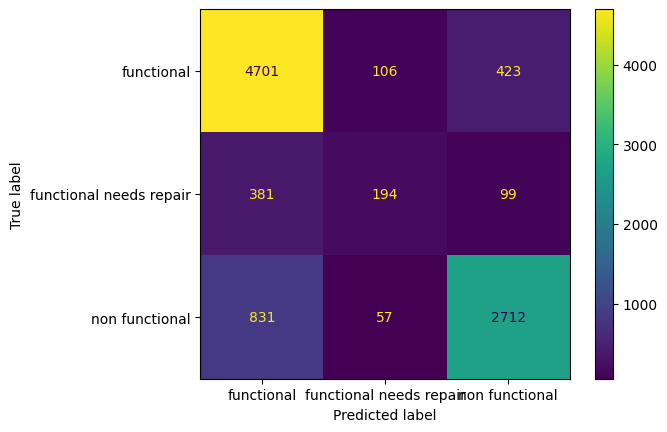

In [ ]:
# Plot 3x3 confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_val, y_val)

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [ ]:
# Print classification report
print(classification_report(y_val, model.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.84      5230
functional needs repair       0.54      0.29      0.38       674
         non functional       0.84      0.75      0.79      3600

               accuracy                           0.80      9504
              macro avg       0.73      0.65      0.67      9504
           weighted avg       0.79      0.80      0.79      9504



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [ ]:
model.predict_proba(X_val)

array([[0.01152972, 0.00569412, 0.98277616],
       [0.83646917, 0.050784  , 0.11274683],
       [0.15665075, 0.6919579 , 0.15139134],
       ...,
       [0.65903865, 0.02295661, 0.31800474],
       [0.68404387, 0.03162186, 0.28433427],
       [0.00240385, 0.0103022 , 0.98729396]])

In [ ]:
X_test_nf = pd.DataFrame(index=X_val.index, data=model.predict_proba(X_val)[:,-1])
X_test_nf.columns={'nonfunctional'}
X_test_nf = X_test_nf.loc[X_test_nf['nonfunctional'] >= 0.95]
X_test_nf

,nonfunctional
id,
29198.0,0.982776
30729.0,0.982478
52227.0,0.995082
7297.0,0.962619
9524.0,0.988409
...,...
51584.0,0.966982
28863.0,0.999569
64168.0,0.997196


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [ ]:
X_test_nf = X_test_nf.merge(df['population'], right_index=True, left_index=True)

In [ ]:
X_test_nf

,nonfunctional,population
id,,
29198.0,0.982776,1.0
30729.0,0.982478,100.0
52227.0,0.995082,1.0
7297.0,0.962619,1.0
9524.0,0.988409,1.0
...,...,...
51584.0,0.966982,25.0
28863.0,0.999569,NaN
64168.0,0.997196,NaN


In [ ]:
X_test_nf = X_test_nf.sort_values(by='population',ascending=False).head(100)

In [ ]:
X_test_nf

,nonfunctional,population
id,,
38195.0,0.969810,6500.0
72622.0,0.996988,6500.0
38443.0,0.993075,2560.0
12032.0,1.000000,2000.0
67219.0,0.978690,2000.0
...,...,...
56186.0,1.000000,400.0
52722.0,0.994098,400.0
72809.0,0.999460,400.0


# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).

In [40]:
X_test_nf = X_test_nf.merge(df['longitude'], right_index=True, left_index=True)
X_test_nf

,nonfunctional,population,latitude,longitude
id,,,,
38195.0,0.969810,6500.0,-5.106122,31.039654
72622.0,0.996988,6500.0,-5.104697,31.039623
38443.0,0.993075,2560.0,-8.117534,31.645537
12032.0,1.000000,2000.0,-10.518319,40.228468
67219.0,0.978690,2000.0,-1.999349,32.899991
...,...,...,...,...
56186.0,1.000000,400.0,-10.414099,40.189479
52722.0,0.994098,400.0,-7.962078,36.846508
72809.0,0.999460,400.0,-2.015530,33.032953


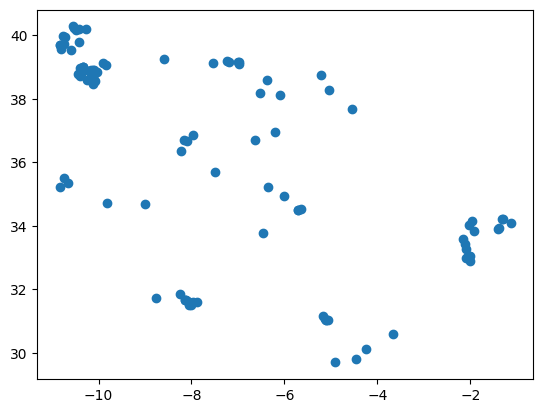

In [43]:
plt.scatter(x='latitude', y='longitude', data=X_test_nf)